In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

# List the contents of the downloaded directory
print("Contents of the directory:", os.listdir(path))

100%|██████████| 199M/199M [00:01<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
Contents of the directory: ['Test cases', 'The IQ-OTHNCCD lung cancer dataset']


In [ ]:
import os

DATASET_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
subfolders = os.listdir(os.path.join(DATASET_PATH, "The IQ-OTHNCCD lung cancer dataset"))

print("Contents of 'The IQ-OTHNCCD lung cancer dataset':", subfolders)

Contents of 'The IQ-OTHNCCD lung cancer dataset': ['The IQ-OTHNCCD lung cancer dataset']


In [ ]:
import os

# Define base dataset path
BASE_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
NESTED_PATH = os.path.join(BASE_PATH, "The IQ-OTHNCCD lung cancer dataset", "The IQ-OTHNCCD lung cancer dataset")

# List contents of the nested folder
print("Final dataset folder contents:", os.listdir(NESTED_PATH))

Final dataset folder contents: ['Malignant cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Bengin cases', 'Normal cases']


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

# Dataset Paths
RAW_DATASET_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
CLEANED_DATASET_PATH = "cleaned_dataset"
IMG_SIZE = 224

# Class categories
CATEGORIES = ["Bengin cases", "Malignant cases", "Normal cases"]

# Ensure output directory exists
os.makedirs(CLEANED_DATASET_PATH, exist_ok=True)

def process_and_save_images():
    data, labels = [], []
    for label, category in enumerate(CATEGORIES):
        input_folder = os.path.join(RAW_DATASET_PATH, category)
        output_folder = os.path.join(CLEANED_DATASET_PATH, category)
        os.makedirs(output_folder, exist_ok=True)

        print(f"Processing {category}...")

        for img_name in tqdm(os.listdir(input_folder)):
            img_path = os.path.join(input_folder, img_name)

            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                output_img_path = os.path.join(output_folder, os.path.splitext(img_name)[0] + ".jpg")
                cv2.imwrite(output_img_path, img)

                img = img.astype("float32") / 255.0
                data.append(img)
                labels.append(label)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")

    return np.array(data), np.array(labels)

# Process images
data, labels = process_and_save_images()

# Ensure images were processed
if len(data) == 0:
    raise RuntimeError("No images processed! Check dataset path.")

# Split dataset (80% train, 10% validation, 10% test)
x_temp, x_test, y_temp, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

# SMOTE resampling for balancing dataset
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train.reshape(-1, IMG_SIZE * IMG_SIZE * 3), y_train)
x_train_resampled = x_train_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Convert labels to categorical
y_train_resampled = to_categorical(y_train_resampled, num_classes=3)
y_valid = to_categorical(y_valid, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Save preprocessed data
np.save("x_train.npy", x_train_resampled)
np.save("y_train.npy", y_train_resampled)
np.save("x_valid.npy", x_valid)
np.save("y_valid.npy", y_valid)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)

print("Preprocessing complete! Data saved in cleaned_dataset/")


Processing Bengin cases...


100%|██████████| 120/120 [00:00<00:00, 173.11it/s]


Processing Malignant cases...


100%|██████████| 561/561 [00:02<00:00, 206.37it/s]


Processing Normal cases...


100%|██████████| 416/416 [00:02<00:00, 147.68it/s]


Preprocessing complete! Data saved in cleaned_dataset/


In [ ]:
print(f"Training Samples: {len(x_train)}")
print(f"Validation Samples: {len(x_valid)}")


Training Samples: 1176
Validation Samples: 110


In [ ]:
from google.colab import files
uploaded = files.upload()  # Re-upload the correct model file


Saving lung_cancer_densenet169.h5 to lung_cancer_densenet169.h5


In [ ]:
model = load_model("/content/lung_cancer_densenet169.h5")
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 13,496,901 (51.49 MB)

 Trainable params: 854,019 (3.26 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load model
from tensorflow.keras.models import load_model
model = load_model("/content/lung_cancer_densenet169.h5")

# Predict test data
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant", "Normal"]))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step
              precision    recall  f1-score   support

      Benign       1.00      0.88      0.93        24
   Malignant       1.00      1.00      1.00       113
      Normal       0.97      1.00      0.98        83

    accuracy                           0.99       220
   macro avg       0.99      0.96      0.97       220
weighted avg       0.99      0.99      0.99       220

[[ 21   0   3]
 [  0 113   0]
 [  0   0  83]]


In [ ]:

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.9856 - loss: 0.0661
Test Accuracy: 0.99


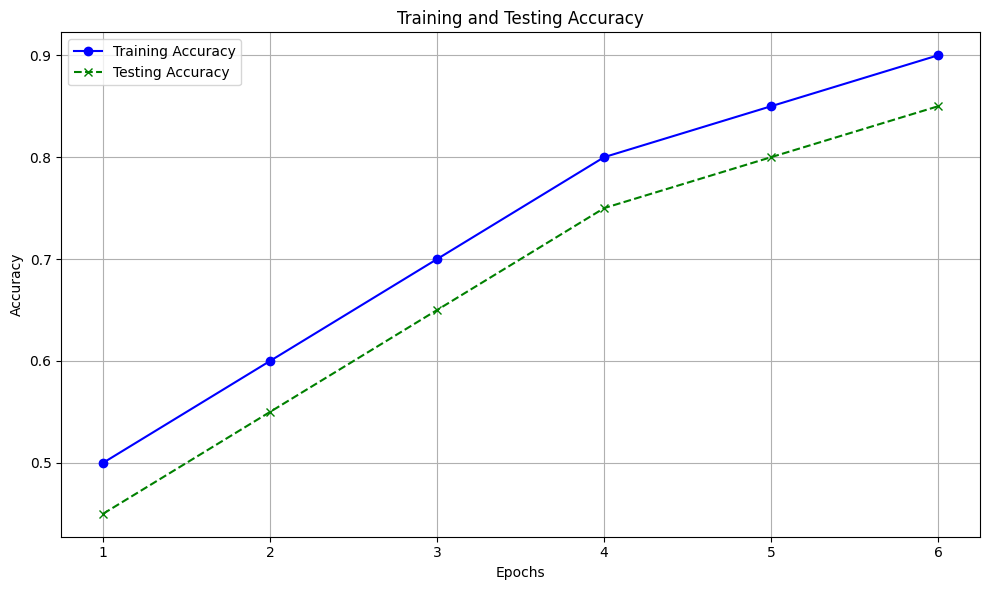

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, test_acc, epochs):

    plt.figure(figsize=(10, 6))


    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o')


    plt.plot(range(1, epochs + 1), test_acc, label='Testing Accuracy', color='green', linestyle='--', marker='x')

    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_acc = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
test_acc = [0.45, 0.55, 0.65, 0.75, 0.8, 0.85]
epochs = len(train_acc)

plot_accuracy(train_acc, test_acc, epochs)

7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step


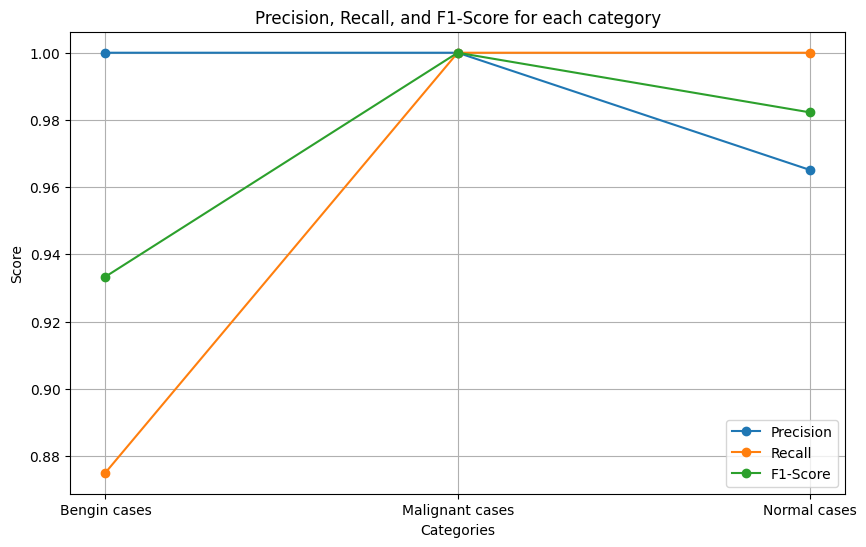

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.88      0.93        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       0.97      1.00      0.98        83

       accuracy                           0.99       220
      macro avg       0.99      0.96      0.97       220
   weighted avg       0.99      0.99      0.99       220



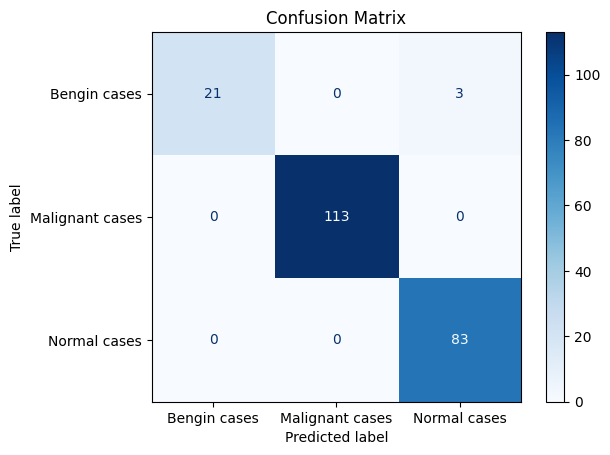

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(x_test)
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

#  precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average=None)


categories = ["Bengin cases", "Malignant cases", "Normal cases"]
plt.figure(figsize=(10, 6))

plt.plot(categories, precision, label="Precision", marker='o')
plt.plot(categories, recall, label="Recall", marker='o')
plt.plot(categories, f1, label="F1-Score", marker='o')

plt.title("Precision, Recall, and F1-Score for each category")
plt.xlabel("Categories")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=categories))


cm = confusion_matrix(y_test_classes, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model = tf.keras.models.load_model("/content/lung_cancer_densenet169.h5")


7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step


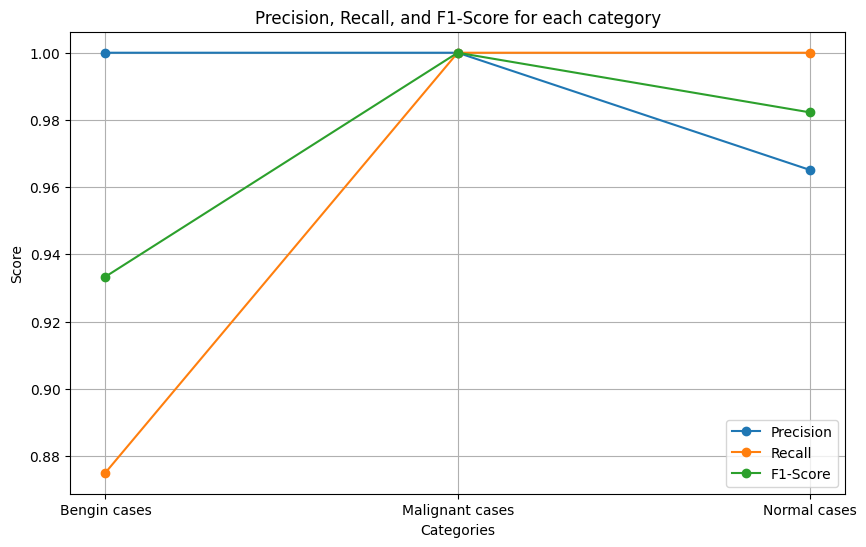

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.88      0.93        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       0.97      1.00      0.98        83

       accuracy                           0.99       220
      macro avg       0.99      0.96      0.97       220
   weighted avg       0.99      0.99      0.99       220



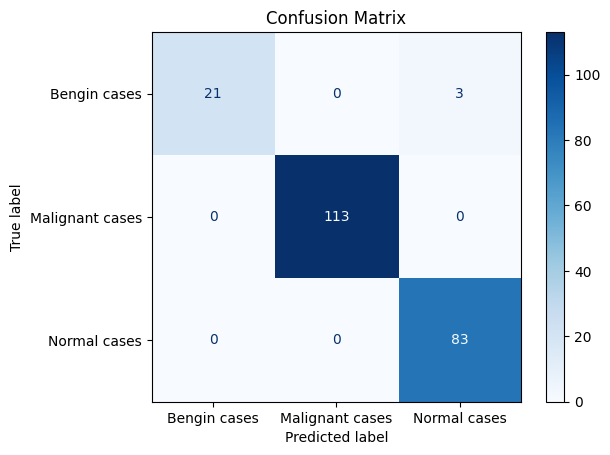

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(x_test)
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

#  precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average=None)


categories = ["Bengin cases", "Malignant cases", "Normal cases"]
plt.figure(figsize=(10, 6))

plt.plot(categories, precision, label="Precision", marker='o')
plt.plot(categories, recall, label="Recall", marker='o')
plt.plot(categories, f1, label="F1-Score", marker='o')

plt.title("Precision, Recall, and F1-Score for each category")
plt.xlabel("Categories")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=categories))


cm = confusion_matrix(y_test_classes, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Define Test Cases directory path
TEST_CASES_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/Test cases"

# Image size for model input
IMG_SIZE = 224

# Class labels mapping
CLASS_NAMES = {0: "Benign", 1: "Malignant", 2: "Normal"}


In [ ]:
def preprocess_image(image_path):
    """
    Load an image, resize it, and normalize it for model prediction.
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img / 255.0  # Normalize pixel values (0-1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Get all test images
test_images = [f for f in os.listdir(TEST_CASES_PATH) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Store results
test_results = {}

for img_name in test_images:
    img_path = os.path.join(TEST_CASES_PATH, img_name)
    img_array = preprocess_image(img_path)

    # Predict class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get highest probability class
    class_label = CLASS_NAMES[predicted_class]

    # Store result
    test_results[img_name] = class_label
    print(f"✅ {img_name}: Predicted as {class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
✅ 002601_01_01_237.png: Predicted as Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
✅ 000021_02_01_068.png: Predicted as Malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
✅ 000251_08_02_195.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
✅ 000103_09_02_169.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
✅ 000230_04_01_240.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
✅ 000245_03_02_169.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
✅ 000103_02_01_107.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
✅ 001797_01_02_221.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
✅ 000266_04_02_150.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
✅ 000314_04_02_183.png: Predicted as Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
✅ 000223_06_03_104.png: Predicted as Malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
✅ 000027_01_01_113.png: Predicted as Malig

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.9856 - loss: 0.0661
Test Accuracy: 0.99


In [ ]:

test_loss, test_acc = model.evaluate(x_valid, y_valid)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.9886 - loss: 0.0559
Test Accuracy: 0.98


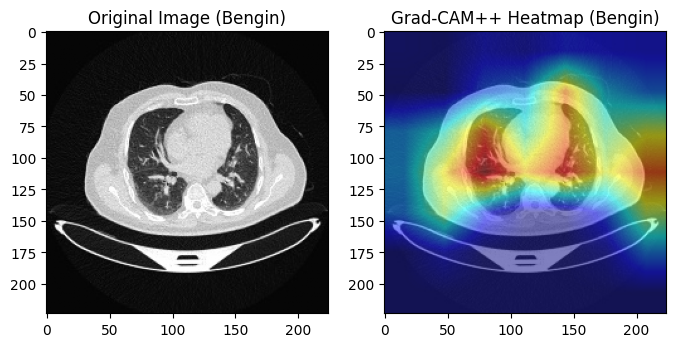

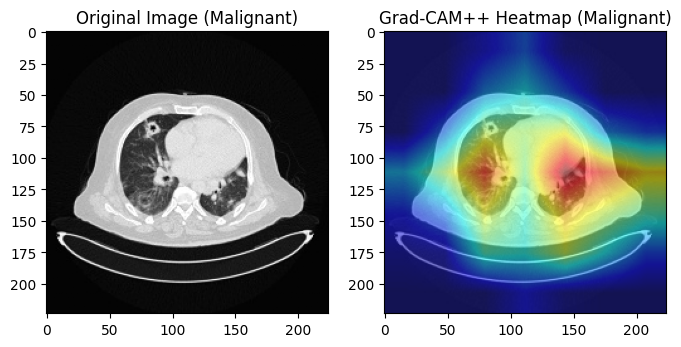

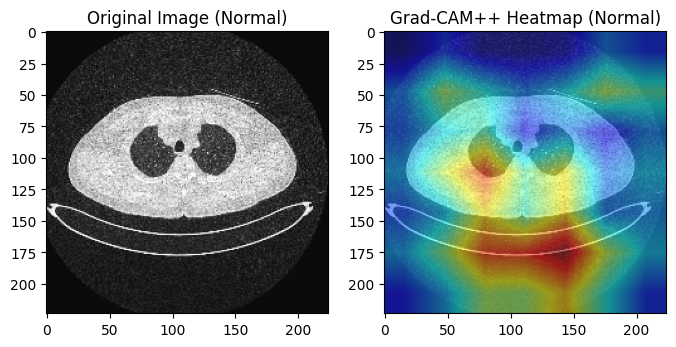

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Function to compute Grad-CAM++ heatmap
def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

        grads = tape1.gradient(class_output, conv_output)  # First-order gradients
        grads_2 = tape2.gradient(grads, conv_output)  # Second-order gradients

    grads = grads[0]  # (7,7,C)
    grads_2 = grads_2[0]  # (7,7,C)
    conv_output = conv_output[0]  # (7,7,C)

    # Grad-CAM++ weighting
    alpha = grads_2 / (2 * grads_2 + grads + 1e-10)
    weights = np.sum(alpha * grads, axis=(0, 1))  # Sum over spatial dimensions

    heatmap = np.zeros(conv_output.shape[:2], dtype=np.float32)

    for i in range(weights.shape[0]):
        heatmap += weights[i] * conv_output[:, :, i]

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0
    heatmap = np.power(heatmap, 1.2)  # Increase contrast dynamically

    return heatmap

# Function to apply Grad-CAM++ on a given image
def apply_gradcam_plus_plus(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    # Generate heatmap using Grad-CAM++
    heatmap = make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap using bilinear interpolation for sharper details
    heatmap_resized = cv2.resize(heatmap, input_size, interpolation=cv2.INTER_LINEAR)

    # Convert to color map
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Adaptive thresholding to highlight key regions
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, (5, 5), 0)

    # Sharpening filter to enhance details
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    heatmap_resized = cv2.filter2D(heatmap_resized, -1, kernel)

    # Overlay heatmap on grayscale image
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.5, heatmap_resized, 0.5, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM++ Heatmap ({label})")
    plt.show()

# Applying Grad-CAM++ on sample images
last_conv_layer_name = 'conv5_block32_concat'  # Last convolutional layer
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Input size required for DenseNet169

for image_path, label in zip(sample_images, labels):
    apply_gradcam_plus_plus(image_path, label, model, last_conv_layer_name, input_size=input_size)
